# Предсказание рыночной цены автомобиля

Сервис по продаже автомобилей с пробегом хочет привлечь новых клиентов и разрабатывает приложение, с помощью которого можно быстро узнать рыночную стоимость своего автомобиля.

# Цель проекта

Построить модель, решающую задачу регрессии и предсказывающую рыночную цену автомобилей по данным об их технических характеристиках и комплектации. При построении модели нужно найти баланс между качеством, скоростью предсказаний и временем обучения.

# План работы

1. Знакомство с данными и предобработка - посмотрим, какие данные имеются в нашем распоряжении. Если в данных окажутся дубликаты, пропуски (явные и неявные), аномалии или артефакты, то попробуем их исправить (или удалить).


2. Подготовка признаков - определим, какие данные и в каком видем будут переданы в модель. Выберем подходящий способ кодирования признаков. 

3. Построение модели - сформируем выборки и обучим несколько моделей (логистическую регрессию, случайный лес и модель, работающую по алгоритму градиентного бустинга). Сравним качество предсказаний (метрика качества - RMSE), проведем анализ остатков для лучшей модели.

4. Подготовка отчета - сформулируем выводы и оценим результаты работы.

***

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import time # импорт библиотеки для подсчета времени исполнения кода

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

# импоритируем структуры данных для постройки базовых моделей
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
# импортируем структуры данных для кодирования признаков
from category_encoders import OrdinalEncoder, TargetEncoder 
# импорт библиотеки для градиентного бустинга
import lightgbm as lgb
print('Импорт библиотек - ОК')

Импорт библиотек - ОК


# Пользовательские функции

Объявим пользовательские функции:
- **timer** вычисляет скорость работы моделей;
- **encoder** кодирует категориальные признаки
- **chart_feature_imp** строит график значимости признаков

In [2]:
def timer(start, stop):
    time = stop - start
    m, s = divmod(time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    return '{0:02d}:{1:02d}:{2:02d}'.format(h, m, s)

In [3]:
# функция encoder принимает на вход категориальные признаки и возвращает их в кодированном виде
def encoder(features_train, features_test, target_train):
    
    # 1
    # закодируем порядковые категориальные данные о пробеге с помощью ordinal encoding
    # создадим словарь кодирования категорий
    oe_mapping = [
        {'col':'kilometer',
        'mapping': 
        {5000:1,
         10000:2,
         20000:3,
         30000:4,
         40000:5,
         50000:6,
         60000:7,
         70000:8,
         80000:9,
         90000:10,
         100000:11,
         125000:12,
         150000:13}        
        }
    ]
    # создадим объект структур данных OrdinalEncoder и передаем в него словарь oe_mapping
    encoder = OrdinalEncoder(mapping = oe_mapping, return_df = True)  
    # закодируем данные о пробеге в обучающей и тестовой выборке
    encoded_features_train = encoder.fit_transform(features_train)
    encoded_features_test = encoder.transform(features_test)
    
    # 2
    # закодируем номиральные признаки из списка ohe_list методом one-hot encoding
    # добавим их к таблицам encoded_data_train, encoded_data_test
    ohe_list = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired'] 
    encoded_features_train = pd.concat([encoded_features_train,
                                    pd.get_dummies(encoded_features_train[ohe_list], drop_first=True)], axis=1)
    encoded_features_test = pd.concat([encoded_features_test,
                                    pd.get_dummies(encoded_features_test[ohe_list], drop_first=True)], axis=1)
    
    # 3
    # закодируем номиральные признаки brand и model с помощью target encoding
    encoder = TargetEncoder(cols=['brand', 'model']) 
    encoded_features_train = encoder.fit_transform(encoded_features_train, target_train)
    encoded_features_test = encoder.transform(encoded_features_test)
    
    # 4
    # удалим исходные незакодированные признаки
    encoded_features_train = encoded_features_train.drop(ohe_list, axis=1)
    encoded_features_test = encoded_features_test.drop(ohe_list, axis=1)
    
    
    return encoded_features_train, encoded_features_test   

## Загрузка и знакомство с данными

In [4]:
try:
    df = pd.read_csv('autos.csv')
    print('Данные загружены.')
    print(f'Количество объектов - {df.shape[0]}, количество признаков - {df.shape[1]}.')
    print('Дата последней выгрузки данных:', df['DateCrawled'].max())
except:
    print('Указан некорректный путь к датасету или не подгружены библиотека pandas')

Данные загружены.
Количество объектов - 354369, количество признаков - 16.
Дата последней выгрузки данных: 2016-04-07 14:36:58


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Категориальные признаки:
- `VehicleType` — тип автомобильного кузова;
- `Gearbox` — тип коробки передач;
- `Model` — модель автомобиля;
- `FuelType` — тип топлива;
- `RegistrationMonth` — месяц регистрации автомобиля;
- `Brand` — марка автомобиля;
- `Repaired` — была машина в ремонте или нет;
- `PostalCode` — почтовый индекс владельца анкеты (пользователя);
- `Kilometer` — пробег (км)

Численные признаки:
- `RegistrationYear` — год регистрации автомобиля;
- `Power` — мощность (л. с.);
- `NumberOfPictures` — количество фотографий автомобиля;

Временные метки:
- `DateCrawled` — дата скачивания анкеты из базы;
- `DateCreated` — дата создания анкеты;
- `LastSeen` — дата последней активности пользователя

Целевой признак:
- `Price` — цена (в евро)

**Наблюдения** 

- Последние данные были выгружены из базы в апреле 2016 года.
- Среди признаков присутсвуют как категориальные, так и численные переменные.
- В данных есть пропуски. Больше всего - в колонке `Repaired` (была машина в ремонте или нет). Возможно ряд пользователей заполняли эту графу только в случае, если машина была в ремонта.
- Признаки, содержащие временные метки (`DateCrawled`, `DateCreated`, `LastSeen`), можно сразу исключить из таблицы. Для прогнозирования автомобиля они не пригодятся. 
- Данные о месяце регистрации автомобиля (при наличие данных о годе регистрации) представляются излишними. Признак `RegistrationMonth` можно исключить.
- Судя по описанию данных, `PostalCode` - это почтовый индекс пользователя. Значит ли это, что автомобиль находится там же? Важны ли эти данные?

## Подготовка данных

### Первичная обработка признаков

Начнем с опеределения мусорных признаков, которые не нужно передавать в модель.

- Посмотрим на содержание колонки `PostalCode`. Цена на автомобили указаны в евро. Можно предположить, что все пользователи разместившие объявления, находятся в Европе. Проверив несколько случайных почтовых индексов и посмотрев их географическую привязку, удалось установлить, что почтовые индексы не уникальные даже на территории Европы. Например, индекс 34385 может принадлежать как Германии, так и Индонезии, Израилю, Максике, Южной Корее, Турции и Украине. Следовательно интерпретировать почтовый индекс пользователя, как место хранения автомобиля, не получится. Значит пользы от этих данных нет - удалим колонку `PostalCode`.

- Будем считать, что дата публикации объявления, активность пользователя и дата выгрузки данных не влияют на оценку стоимости автомобиля, - исключим из признаков временные метки `DateCrawled`, `DateCreated`, `LastSeen`.

- Для оценки возраста автомобиля достаточно года регистрации - исключим колонку `RegistrationMonth`.

In [6]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'RegistrationMonth'])




Можно предположить, что продавая машину "по-дешёвке" пользователь не будет утруждать себя подготовкой большого количества фотографий и наоборот. Посмотрим на данные в колонке `NumberOfPictures`.

In [7]:
df['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

Фотографий нет. Вероятно при выгрузке произошлка какая-то ошибка и все данные обнулились - от колонки `NumberOfPictures` можно избавиться.

In [8]:
df = df.drop(columns=['NumberOfPictures'])

Мы избавились от мусорной информации. Теперь приведем названия колонок к "змеиному" регистру для удобства дальнейшей работы.

In [9]:
# переведем весь штриф в нижний регистр
df.columns = df.columns.str.lower()
# расставим пробелы
df.rename(columns=
          {'vehicletype':'vehicle_type',
           'registrationyear': 'registration_year',
           'fueltype':'fuel_type', 
           'Repaired':'repaired'}, inplace=True)

In [10]:
print('Наименования колонок отредактированы.')
df.columns

Наименования колонок отредактированы.


Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

### Обработка дубликатов

In [11]:
print('Количество полных дубликатов строк в таблице:', df.duplicated().sum())

Количество полных дубликатов строк в таблице: 45040


После удаления временнных меток стало видно, что 12% данных - дубликаты. Похоже, что система позволяла пользователям размещать одно и то же объявление многократно. Удалим повторы.

In [12]:
# удалим дубликаты и сбросим индексы
df = df.drop_duplicates().reset_index(drop=True)

### Обработка аномалий и пропусков

#### Дата регистрации автомобиля
Исследуем данные о времени регистрации автомобиля. Посление данные были выгружены из базы в апреле 2016. Это значит, что все значения даты регистрации автомобилей позже 2016 года - ошибочны. По диаграмме размаха определим нижнюю границу выбросов в колонке `registration_year`.

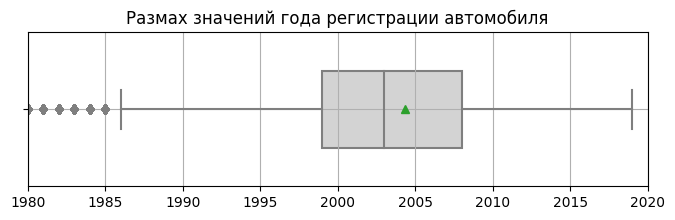

In [13]:
plt.subplots(figsize=(8, 2))
sns.boxplot(data=df, x='registration_year', width=0.5, color='lightgray', showmeans=True, showfliers=True, orient='h')
plt.title('')
plt.grid(True)
plt.title('Размах значений года регистрации автомобиля')
plt.xlabel('')
plt.xlim(1980, 2020);

Нижняя граница выбросов - 1986 год.

In [14]:
# подсчитаем долю записей с годом регистрации автомобиля до 1986 или после 2016
print('Доля аномальных значений -','{:.0%}'.format(
    len(df[(df['registration_year'] < 1986) | (df['registration_year'] > 2016)]) / len(df)
       ))

Доля аномальных значений - 6%


Удалим аномальные записи.

In [15]:
df = df[(df['registration_year'] > 1985) & (df['registration_year'] < 2017)]

#### Тип коробки передач
С этим данными все в порядке. Пропуски уместно заполнить значением `unknown`.

In [16]:
print('Варианты коробоки передач:', df['gearbox'].unique())

Варианты коробоки передач: ['manual' 'auto' nan]


In [17]:
df['gearbox'] = df['gearbox'].fillna('unknown')

#### Мощность автомобилей

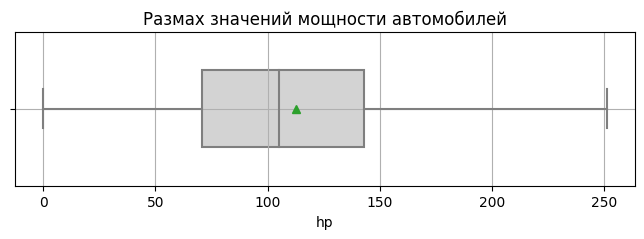

In [18]:
plt.subplots(figsize=(8, 2))
sns.boxplot(data=df, x='power', width=0.5, color='lightgray', showmeans=True, showfliers=False, orient='h')
plt.grid(True)
plt.title('Размах значений мощности автомобилей')
plt.xlabel('hp');

In [19]:
print('Доля автомобилей с мощностью больше 250 hp -','{:.2%}'.format(
    len(df[df['power']>250]) / len(df)
       ))
print('Доля автомобилей с мощностью меньше 70 hp -','{:.2%}'.format(
    len(df[df['power']<70]) / len(df)
       ))

Доля автомобилей с мощностью больше 250 hp - 2.23%
Доля автомобилей с мощностью меньше 70 hp - 24.39%


За границами "усов" графика отказались записи об автомобилях мощностью более 250 л.с. Расширим этот диапазон до 500 л.с., чтобы учесть мощные серийные автомобили. Остальное будем считать выбросами и избавимся от них.

In [20]:
df = df[df['power'] <= 500]

Четверть записей содержат необычно низкие значения мощности. Посмотрим на распределение этих данных.

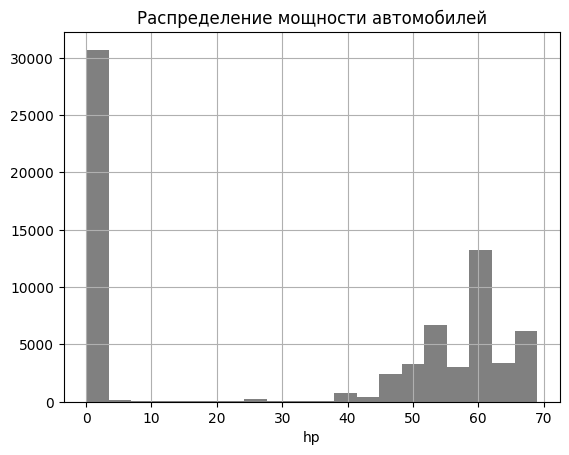

In [21]:
df[df['power'] < 70]['power'].hist(bins = 20, color='gray')
plt.title('Распределение мощности автомобилей')
plt.xlabel('hp')
plt.ylabel('');

Нулевое значение в данных о мощности двигателя - это пропуск, обозначенный константой. Единичные значения ниже 40 hp выглядят неправдоподобно. Предположим, что эти данные ошибочны,и попробуем их исправить. Для этого найдем найдем похожие автомобили (той же марки и модели) и воспользуемся медианным значеним мощности для каждой группы.

In [22]:
# сгрупируем записи по колонкам brand, model
# и заменим нули в колонке power медианными значениями
df.loc[df['power'] < 40, 'power'] = (
    df.groupby(['brand','model'])['power'].transform('median')
)

print('Доля аномальных записей после обработки -', '{:.2%}'.format(len(df[df['power'] < 40]) / len(df)))

Доля аномальных записей после обработки - 0.09%


Указанный подход позволил нам свести случаи пропусков (нулей) в колонке `power` к единичным - удалим их.

In [23]:
# обновим набор данных, исключив мусорные записи
df = df.loc[df['power'] >= 40]

#### Марки и модели автомобилей 
В данных есть записи об автомобилях, содержащие только наименование марки. В таких случаях будет уместно заполнить пропуски в указании конкретных моделей значением `unknown`.

In [24]:
print('Количестов уникальных марков автомобилей -', len(df['brand'].unique()))
print('Пропусков в данных -', df['brand'].isna().sum())
print('Количестов уникальных моделей автомобилей -', len(df['model'].unique()))
print('Пропусков в данных -', df['model'].isna().sum())

Количестов уникальных марков автомобилей - 40
Пропусков в данных - 0
Количестов уникальных моделей автомобилей - 248
Пропусков в данных - 10600


In [25]:
df['model'] = df['model'].fillna('unknown')

#### Пробег
Данные о пребеге записаны в виде интервалов. Это значит, что признак `kilometer` не численный, а категориальный (порядковый). Аномальных значений пробега нет.

In [26]:
df['kilometer'].value_counts()

150000    188618
125000     30751
100000     12260
90000       9801
80000       8481
70000       7368
60000       6202
50000       5226
40000       4114
5000        4105
30000       3645
20000       3205
10000        883
Name: kilometer, dtype: int64

#### Тип топлива

In [27]:
df['fuel_type'].value_counts()

petrol      175838
gasoline     81452
lpg           4651
cng            492
hybrid         210
other           87
electric        64
Name: fuel_type, dtype: int64

В Англии стандартное топливо для ДВС назвывают petrol, в США - gasoline. Уницифируем эти два термина - benzine.

In [28]:
# заменим petrol/gasoline в колонке fuel_type на benzine
df.loc[(df['fuel_type'] == 'petrol') | (df['fuel_type'] == 'gasoline'), 'fuel_type'] = 'benzine'

Пропуски в колонке `fuel_type` будет уместно заполнить значением `unknown`.

In [29]:
df['fuel_type'] = df['fuel_type'].fillna('unknown')

#### Записи о ремонтах

In [30]:
print('Варианты записей о ремонтах:', df['repaired'].unique())

Варианты записей о ремонтах: [nan 'yes' 'no']


В колонке `repaired` аномальных значений нет. Предположим, что пропуски в этой колонке означают, что машина не была в ремонте, и заполним их значением `no`.

In [31]:
# заполним пропуски в данных о ремонте    
df['repaired'] = df['repaired'].fillna('no')

#### Цены на автомобили

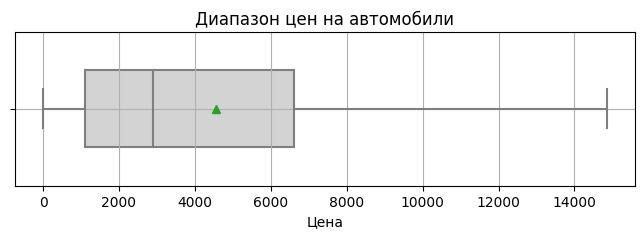

In [32]:
plt.subplots(figsize=(8, 2))
sns.boxplot(data=df, x='price', width=0.5, color='lightgray', showmeans=True, showfliers=False, orient='h')
plt.grid(True)
plt.title('Диапазон цен на автомобили')
plt.xlabel('Цена');

Четверть набора данных - это записи об автомобилях дешевле 1000 евро. Посмотрим на распределение цен в этом диапазоне.

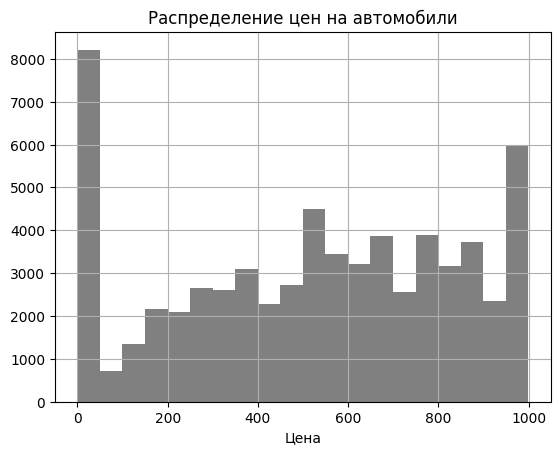

In [33]:
df[df['price'] < 1000]['price'].hist(bins = 20, color='gray')
plt.title('Распределение цен на автомобили')
plt.xlabel('Цена')
plt.ylabel('');

Много "бесплатных" автомобилей - в данных какая-то ошибка. Кроме того, немало записей о явно неадектно низкой стоимости. Эмпирически установим минимальную стоимость самого "убитого" автомобиля в 200 евро (по цене автолома) и исключим все записи о более дешевых автомобилях. Будем считать, что автомобиль в состоянии "на 200 евро" не будут продавать по объявлению, а сдадут в металлолом.

In [34]:
# отфильтруем записи о слишком дешевых автомобилях
df = df[df['price'] >= 200]

#### Тип кузова
Все значения колонки `vehicle_type` адекватные.

In [35]:
print('Варианты типов кузова:', df['vehicle_type'].unique())
print('Доля пропусков -', '{:.0%}'.format(df['vehicle_type'].isna().mean()))

Варианты типов кузова: [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Доля пропусков - 5%


Заполним пропуски в колонке `vehicle_type` самым распространенным типов кузова для каждой марки автомобиля.

In [36]:
# заполним пропуски в данных о типе кузова самым частым значеним
# довим условие, чтобы избежать ошибки при отсутсвии пропусков в группах

df['vehicle_type'] = df['vehicle_type'].fillna(
    df.groupby(['brand','model'])['vehicle_type'].transform(
        lambda x: x.mode()[0] if not x.mode().empty else np.nan)
)

In [37]:
print('Количество пропусков в данных после обработки -', df.isna().sum().sum())

Количество пропусков в данных после обработки - 0


Обработка аномалий и пропусков завершена.

### Подготовка выборок
Отделим тестовую выборку в размере 25% данных.

In [38]:
target = df['price']
features = df.drop(['price'] , axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

### Кодирование признаков

Условие заказчика - выдержать баланс между качеством, скоростью предсказаний и временем обучения модели. Изучив признаки, в настоящем исследовании поступим так:

- Для кодирования номинальных признаков при сравнительно малом разнообразии значений используем **One-Hot Encoding**. Простой и понятный метод, не создающий ложных зависимостей между закодированными значениями признаков. Применим этот метод к колонкам `vehicle_type`, `gearbox`, `fuel_type`, `repaired`.

- Там, где применение One-Hot Encoding невозможно из-за чрезмерного увеличения объема наших данных (при кодирования номинальных признаков при широком разнообразии значений) используем **Target encoding** - закодируем категории, используя данные о значении целевого признака внутри кодируемой переменной. Обучающая и тестовая выборка разделены случайным образом, следовательно и распределения значений признаков в них должны быть похожи. Такой прием установит связь между целевым признаком и кодируемой категорией. Применим этот метод к колонкам `model`, `brand`.   

- Для кодирования порядковых признаков используем **Ordinal encoding**, составив вручную словарь кодировки для сохранения существующих зависимостей в данных. Применим этот метод к колонке `kilometer`, в которой записаны данные о интервалах пробега.

- Численные признаками `registration_year`, `power` оставим без обработки.

Закодируем признаки обучающей и тестовой выборки с помощью пользовательской функции **encoder**.

In [39]:
encoded_features_train, encoded_features_test = encoder(features_train, features_test, target_train)
print(f'Размерность матрицы исходных признаков - {features_train.shape[1]}')
print(f'Размерность матрицы закодированных признаков - {encoded_features_train.shape[1]}')

Размерность матрицы исходных признаков - 9
Размерность матрицы закодированных признаков - 21


Признаки обучающей и тестовой выборки закодированы и подготовлены для передачи в модель.

## Обучение моделей

Проведем эксперимент и сравним качество предсказаний моделей, работающих по алгоритму линейной регрессии, случайного леса и градиентного бустинга. Метрика качества - среднеквадратичная ошибка **RMSE**. Обучать модели будем методом кросс-валидации.

В качестве точки отсчета и меры адекватности рабочих моделей возьмем предсказания наивной модели, которая всегда предсказывает среднее значение целевого признака.

In [62]:
# инициируем наивную модель
dummy = DummyRegressor(strategy='mean')
dummy.fit(encoded_features_train, target_train)
dummy_pred = dummy.predict(encoded_features_test)

print(f'Наивная модель.\nКонтрольное значение RMSE: \
{int(mean_squared_error(target_test, dummy_pred, squared=False))}')

Наивная модель.
Контрольное значение RMSE: 4591


In [41]:
# соберем сравнительную таблицу models, в которую будем записывать характеристики моделей

models = pd.DataFrame(index = ['lr', 'rf', 'lgbm'],
                      data = {'RMSE' : [0, 0, 0],
                      'training_time' : [0, 0, 0],
                      'prediction_time' : [0, 0, 0],
                      'parameters' : ['', '', '']})

### Линейная регрессия

In [42]:
# инициируем и обучим модель
lr = LinearRegression()
# значения полученных методом кросс-валидации метрик RMSE запишем в scores
lr_scores = cross_val_score(lr, encoded_features_train, target_train, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
print(f'Алгоритм линейной регрессии.\nКросс-валидация.\nRMSE: {int(abs(lr_scores.mean()))}')

# измеряем время обучения фиксируем его в таблице
start = time.time() 
lr.fit(encoded_features_train, target_train)
stop = time.time() 

models.loc['lr','training_time'] = timer(start, stop)

Алгоритм линейной регрессии.
Кросс-валидация.
RMSE: 2686


### Cлучайный лес

In [43]:
%%time
# установим диапазон перебора гиперпараметров
parametrs = {'n_estimators': range(20, 100, 10), 'max_depth': range(15, 50, 5)}

# инициируем модель
rf = RandomizedSearchCV(
    RandomForestRegressor(random_state=12345), param_distributions=parametrs,
    scoring='neg_root_mean_squared_error', n_iter=10, cv=3, n_jobs=-1)

# выбираем гиперпараметры
rf.fit(encoded_features_train, target_train)

print('Алгоритм случайного леса.\nВыбор гиперпараметров методовRandomizedSearchCV.')
print(f'RMSE: {abs(rf.best_score_):.2f}')
print('Глубина дерева:', rf.best_params_.get('max_depth'))
print('Количество деревьев:', rf.best_params_.get('n_estimators'))

# измеряем время обучения лучшей модели
start = time.time() 
rf.best_estimator_.fit(encoded_features_train, target_train)
stop = time.time()

# записываем в сравнительную таблицу время обучение и параметры модели
models.loc['rf','training_time'] = timer(start, stop)
models.loc['rf','parameters'] = str(rf.best_params_)

Алгоритм случайного леса.
Выбор гиперпараметров методовRandomizedSearchCV.
RMSE: 1621.62
Глубина дерева: 20
Количество деревьев: 80
CPU times: total: 2min 26s
Wall time: 10min 33s


### Градиентный бустинг
#### LightGBM
Средствами библиотеки **LightGBM** реализуем алгоритм градиентного бустинга на решающих деревьях. Для регуляризации алгоритма будем изменять значения скорости обучения `learning_rate`, максимальной глубины деревьев `max_depth`, количества моделей в ансамбле `n_estimators` и доли признаков `colsample_bytree`, передаваемых в каждое дерево.

Модель LGBMRegressor принимает в том числе не кодированные признаками. Проведем эксперимент и определим, как изменится ошибка предсказаний на обучающей выборке, если передать в модель исходные признаки `vehicle_type`, `gearbox`, `category`, `model`, `category`, `fuel_type`, `brand`, `repaired`. 

In [78]:
%%time
print('Алгоритм градиентного бустинга.')
# установим диапазон перебора гиперпараметров
parametrs = {'learning_rate': [0.1, 0.2, 0.3],
             'max_depth': [2, 10, 20],
             'n_estimators': [100, 200, 300],
             'colsample_bytree': [0.7, 0.8, 1],}
  
# инициируем метод GridSearch
lgbm_gs = GridSearchCV(
    lgb.LGBMRegressor(random_state=12345), param_grid=parametrs,
    scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1)
 
# выбираем гиперпараметры модели на кодированных признаках
encoded_gs = lgbm_gs.fit(encoded_features_train, target_train)
print('RMSE модели, обученной на кодированных признаках:', int(abs(encoded_gs.best_score_)))

# размечаем категориальные признаки
raw_features_train = features_train.astype({
    'vehicle_type':'category',
    'gearbox':'category',
    'model':'category',
    'fuel_type':'category',
    'brand':'category',
    'repaired':'category'})
# выбираем гиперпараметры модели на сырых признаках
raw_gs = lgbm_gs.fit(raw_features_train, target_train)
print('RMSE модели, обученной на сырых признаках:', int(abs(raw_gs.best_score_)))

if abs(encoded_gs.best_score_) < abs(raw_gs.best_score_):
    print('Ошибка модели, работающей с заранее закодированными данными, ниже.')
    # измеряем время обучения лучшей модели
    start = time.time() 
    encoded_gs.best_estimator_.fit(encoded_features_train, target_train)
    stop = time.time()
    # записываем в сравнительную таблицу время обучение и параметры модели
    models.loc['lgbm','training_time'] = timer(start, stop)
    models.loc['lgbm','parameters'] = str(encoded_booster.best_params_)
    # записываем результат работы метода GridSearch в переменную result
    result = encoded_gs
else:
    print('Ошибка модели, работающей с сырыми данными, ниже.')
    # измеряем время обучения лучшей модели
    start = time.time() 
    raw_gs.best_estimator_.fit(raw_features_train, target_train)
    stop = time.time()
    # записываем в сравнительную таблицу время обучение и параметры модели
    models.loc['lgbm','training_time'] = timer(start, stop)
    models.loc['lgbm','parameters'] = str(raw_booster.best_params_)
    # записываем результат работы метода GridSearch в переменную result
    result = raw_gs
    
print('\nГиперпараметры лучшей модели.')
print('Количество моделей в ансамбле:', result.best_params_.get('n_estimators'))
print('Размер подвыборки:', result.best_params_.get('colsample_bytree'))
print('Максимальная глубина дерева:', result.best_params_.get('max_depth'))
print('Скорость обучения:', result.best_params_.get('learning_rate'))

# запишем лучшую модель в переменную booster
booster = result.best_estimator_

Алгоритм градиентного бустинга.
RMSE модели, обученной на кодированных признаках: 1570
RMSE модели, обученной на сырых признаках: 1560
Ошибка модели, работающей с сырыми данными, ниже.

Гиперпараметры лучшей модели.
Количество моделей в ансамбле: 300
Размер подвыборки: 1
Максимальная глубина дерева: 20
Скорость обучения: 0.2
CPU times: total: 37.3 s
Wall time: 11min 16s


Модели обучены. На валидационной выборке лучшие результаты показала модель, работающая по алгоритму градиентного бустинга. Метрики качества предсказаний моделей, обученных на сырых признаках и кодированных внучную признаков, отличаются менее, чем на 1% - кодировать признаки вручную нецелесообразно.

## Тестирование моделей
Сравним качество и скорость их работы обученных моделей на тестовой выборке.

In [103]:
# запишем в сравнительную таблицу полученные на тестовой выборке значения RMSE
# и скорости предсказания обученных моделей 
model_list = [lr, rf.best_estimator_]
# линейную регрессию и случайный лес протестируем на закодированных вручную данных
for i, model in enumerate(model_list):
    start = time.time() 
    models.iloc[i, models.columns.get_loc('RMSE')] = int(mean_squared_error(target_test,
                                                                            model.predict(encoded_features_test),
                                                                            squared=False))
    stop = time.time()
    models.iloc[i, models.columns.get_loc('prediction_time')] = timer(start, stop)

In [111]:
# градиентный бустинг протестируем на сырых данных
raw_features_test = features_test.astype({'vehicle_type':'category',
                                          'gearbox':'category',
                                          'model':'category',
                                          'fuel_type':'category',
                                          'brand':'category',
                                          'repaired':'category'})
start = time.time()
predictions = booster.predict(raw_features_test)
stop = time.time()

# запишем данные в таблицу                         
models.loc['lgbm', 'RMSE'] = int(mean_squared_error(target_test, predictions, squared=False))
models.loc['lgbm', 'prediction_time'] = timer(start, stop)

In [112]:
models.sort_values(by='RMSE')

,RMSE,training_time,prediction_time,parameters
lgbm,1546,00:00:03,00:00:01,"{'colsample_bytree': 0.7, 'learning_rate': 0.2..."
rf,1589,00:01:16,00:00:02,"{'n_estimators': 80, 'max_depth': 20}"
lr,2683,00:00:00,00:00:00,


Тестирование показало, что среднеквадратичная ошибка предсказаний модели, обученной по алгоритму градиентного бустинга и работающей на сырых данных, ниже, чем у моделей, обученных по алгоритму случайного леса или линейной регрессии и работающих с вручную закондированными данными. Скорость предсказаний обученных моделей одинакова - они быстрые.

## Оценка характеристик итоговой модели
Определим признаки, которые являются самыми важными для LGBM-модели в задаче оценки автомобиля.

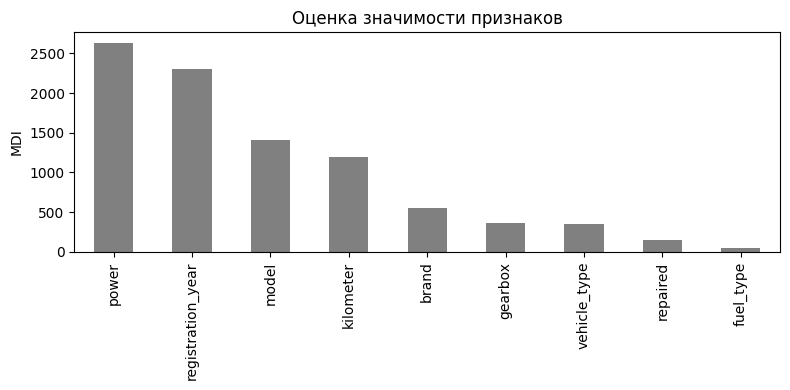

In [113]:
# визуализируем показатели важности признаков, обратившись к атрибуту feature_importances_
model_importances = pd.Series(booster.feature_importances_,
                              index=features_test.columns).sort_values(ascending=False)

std = np.std([booster.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(8,4))
model_importances.plot.bar(std, ax=ax, color='gray')

ax.set_title('Оценка значимости признаков')
ax.set_ylabel('MDI')
fig.tight_layout()

Ключевые признаки, на которые ориентируется лидирующая модель **LGBMRegressor**, - это модель, мощность и год регистрации автомобиля. Наименее значимый признак - это тип топлива и факт ремонта. Можно предположить, что качество предсказаний улучшиться, если исключить малозначимые признаки и проверить оставшиеся на мультиколлинеарность. 

Визуально оценим величину остатков, где модель чаще всего ошибается и в каких случаях выдает наиболее точный результат. Для анализа выберем три наиболее значимых численных характеристики: мощность, год регистрации и пробег.

In [125]:
# значения остатков запишем в переменную residuals
residuals = target_test - predictions

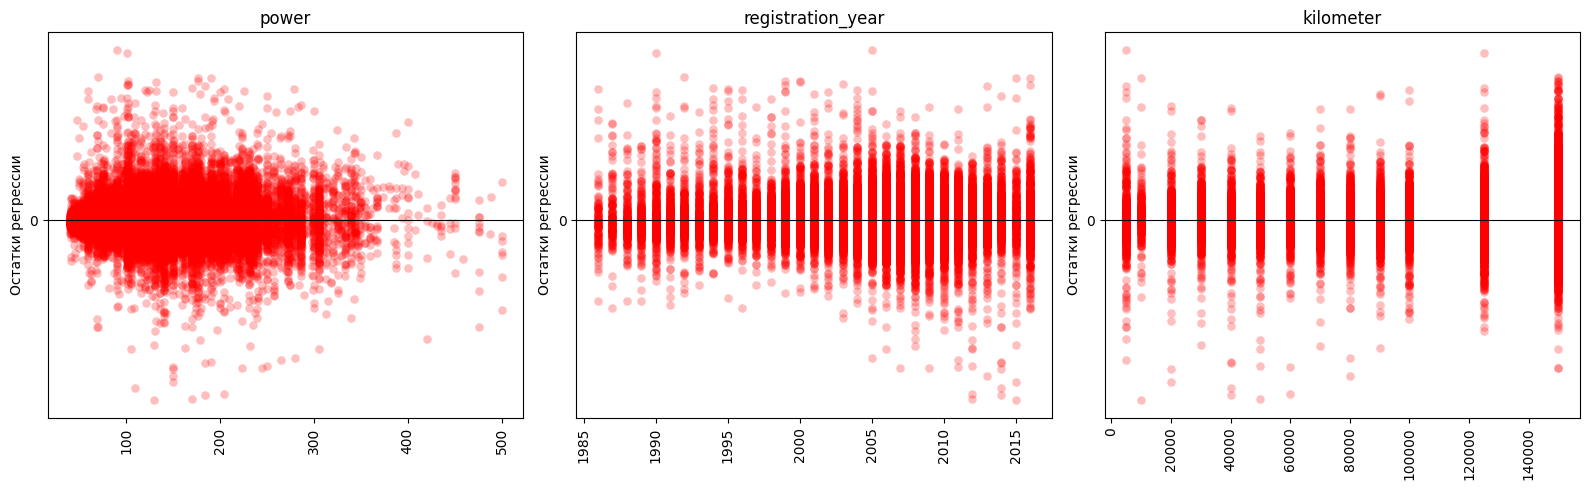

In [197]:
fig = plt.figure(figsize=(16, 5))
for i, feature in enumerate(['power', 'registration_year', 'kilometer']):
    fig.add_subplot(1, 3, i+1)
    plt.scatter(features_test[feature], residuals, color='red', alpha=0.25, linewidths=0.1)
    plt.yticks([0])
    plt.ylabel('Остатки регрессии')
    plt.xticks(rotation='vertical')
    plt.title(feature)
    plt.grid(visible=True, axis='y', color='black')
    plt.tight_layout()

На графиках остатков видно, что модель чаще и значительнее ошибается в предсказании рыночной цены автомобилей в следующих случаях:
- мощность автомобиля в диапазоне от 100 до 200 hp (переоценка и недооценка равновероятны);
- пробег автомобиля меньше 20000 км или больше 140000.

Кроме того, модель ошибается в сторону переоценки для автомобилей старше 2000 года.

## Общий вывод

Цель проекта достигнута. В ходе исследования были построены, обучены и протестированы модели машинного обученя, работающие по алгоритмам линейной регресси, случайного леса, а также ансамбль решающих деревьев, реализующий градиентный бустинг. 

С учетом точности и скорость работы к внедрению рекомендуется модель LMGBRegressor с RMSE 1546, принимающая на вход некодированных признаки.

Предсказания модели могут быть улучшены следующим образом:
- исключением малозначимых признаков: типа топлива, типа кузова и отметки ремонта;
- отбором ведущих признаков путем проверки на мультиколлинеарность;
- генерацией новых признаков, упрощающих работу модели (например категоризировать данные о годе регистрации автомобиля на насколько групп).